In [1]:
# April 2023
# image reconstruction is targete in this notebook

In [2]:
import torch

In [3]:
import numpy as np

In [4]:
import torchvision

In [5]:
# First, a helper is used to show how we can show an image via 
# F.to_pil_image. 
# It's a lot easier to plot cos it also lets me plot torch.tensors.
# Other tools require me to convert it to numpy and do much labour effort...

In [6]:
# So, even a numpy image (of type np.ndarray) 
# or tensor image  (of type torch.tensor)
# can be plotted with this torchvision.transforms.functional


In [7]:
# numpy image:
from matplotlib import image
img1 = image.imread("data/oldman/1.jpg")

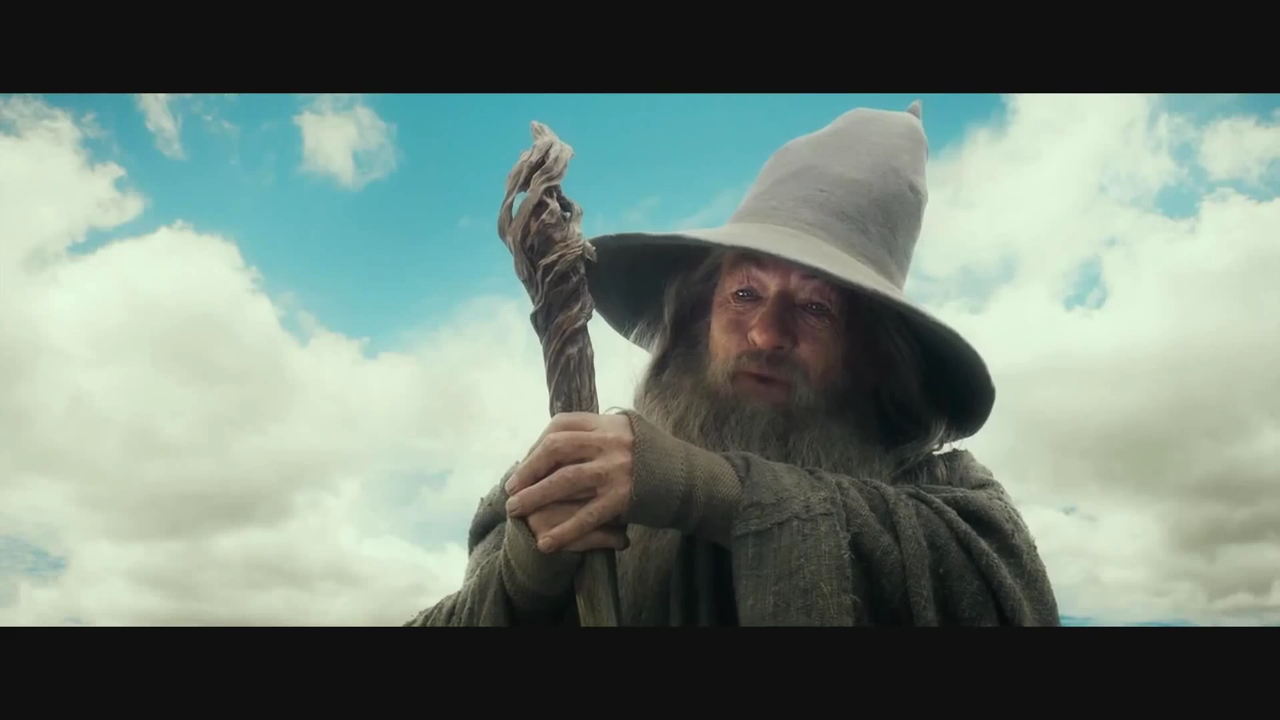

In [8]:
import torchvision.transforms.functional as F
F.to_pil_image(img1)

In [9]:
# torch.tensor image 
img2 = image.imread("data/oldman/1.jpg")
img2 = torch.tensor(img2)

In [10]:
# but the caveat here is to have c*w*h for torch.tensor 
# for plotting with this function. But unfotunately the cell
# above has a w*h*c image.
# later on we will work on it.

In [11]:
# itn't suggested to plot a torch.tensor with w*h*c
# a transofrmation is needed. Later ... you can see it!
img2.shape

torch.Size([720, 1280, 3])

In [12]:
# wihtout transform
# uncomment to see the impact
# import torchvision.transforms.functional as F
# F.to_pil_image(img2.reshape(3,720,1280))

In [13]:
# it is also uncompatiple with PIL.Image as well:

In [14]:
from PIL import Image
img = Image.open("data/oldman/1.jpg")
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [15]:
# uncomment it to see it is troublesome
# F.to_pil_image(img)

In [16]:
# OK. You now understood the importance of tranform for plotting 
# transofmr in vision works can be used for normalizing, resizing
# or channel setting and so forth.

In [17]:
# defining a tranform for transforming the entire images later on
tranform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((150,150)),
#     torchvision.transforms.Normalize((0,0,0), (0.5, 0.5, 0.5)),
        torchvision.transforms.Grayscale(num_output_channels=1),

    
])

In [18]:
tranform(img).shape

torch.Size([1, 150, 150])

In [19]:
# not only for channel setting in c*w*h images, it is highly
# recommended to transorm our images before traning. That is
# the second reason transforms are used.

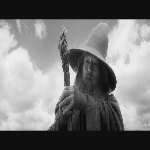

In [20]:
# a sample image before being transformed.
F.to_pil_image(tranform(img))

In [21]:
img_torch = tranform(img)


KeyboardInterrupt



In [ ]:
# that same image after being transformed.
F.to_pil_image(img_torch)

In [ ]:
img_torch.shape

In [ ]:
# now let's work on reconstruction:

In [ ]:
# There are some models in another folder called 'model' folder.
from model.Reconstmodels import (ConvAutoencoder1,
                                 ConvAutoencoder2,
                                 ConvAutoencoder3, 
                                 ConvAutoencoder4)
                                

In [ ]:
# based on need any of models from Reconstmodels.py file can be selected.
# ConvAutoencoder4() is seen the best among all of them. You can see the architecture
# of it to see why.

# net = ConvAutoencoder1()
# net = ConvAutoencoder2()
# net = ConvAutoencoder3()
net = ConvAutoencoder4()

In [ ]:
# but ConvAutoencoder4 is more comfy

In [ ]:
net.encoder_func(img_torch[0].reshape(1,1,150,150)).shape

In [ ]:
net.decoder_func(net.encoder_func(img_torch[0].reshape(1,1,150,150))).shape

In [ ]:
# encoder(img_torch[0].reshape(1,1,150,150)).shape

In [ ]:
# decoder(encoder(img_torch[0].reshape(1,1,150,150))).shape

In [ ]:
# helper
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
# This is how an image is read via mpimg
img = mpimg.imread("img (877).jpg")


In [ ]:
# read the entire images from a folder.
import os
from os import listdir
 
img = []
folder_dir = "data/oldman"
for images_name in os.listdir(folder_dir):
 
    # check if the image ends with png or jpg or jpeg
    if (images_name.endswith(".png") or 
        images_name.endswith(".jpg") or
        images_name.endswith(".jpeg")
       ):
        # display
        img.append(mpimg.imread(folder_dir+"/"+images_name))
        # print(images_name)

In [ ]:
img[0].shape

In [ ]:
# tranform(img[0][:, :, 0:3])

In [ ]:
# img = torch.tensor(img)

In [ ]:
# img.shape

In [ ]:
# transform all the images that already read
# it is highly needed. As images are of form w*d*c but
# for torch and conv layers they must be c*w*d. The toTensor
# transform does it.
img_torch = torch.zeros((len(img), 1,150,150))
for i in range(len(img)):
    img_torch[i, :,:,:] = tranform(img[i]) 

In [ ]:
img_torch.shape

In [ ]:
# plt.imshow(img[80].reshape(720, 1280, 3))

In [ ]:
net.parameters()

In [ ]:
lr= 0.003
params_to_optimize = [{'params':net.parameters()}]

optim = torch.optim.SGD(params_to_optimize, lr=lr, weight_decay=1e-05)

In [ ]:
img_torch[0].shape

In [ ]:
net(img_torch[0].reshape(1,1, 150, 150), 
#     img_torch[2].reshape(1,3, 720, 1280)
   ).shape

In [ ]:
# for i in range(0,10,2):
#     print(i)

In [ ]:
def train_epoch(loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    net.train()
    for epoch in range(200):
        train_loss = []
        # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
        for i in range(0, len(img)-2, 1): 
            
            # two points are inputs
            y_hat = net(img_torch[i].reshape(1,1, 150, 150), 
#                         img_torch[i+2].reshape(1,3, 720, 1280)
                       )
            
            # middle point
            y = img_torch[i].reshape(1,1, 150, 150)
            
            # Evaluate loss
            loss = loss_fn(y, y_hat)
#             print(loss)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
            # Print batch loss
        print(f' epoch: {epoch}:  {np.mean(train_loss)}')
        

    return np.mean(train_loss)

In [ ]:
loss_fn = torch.nn.MSELoss()

In [ ]:
loss_fn(img_torch[0].reshape(1,1, 150, 150), 
        img_torch[2].reshape(1,1, 150, 150)
        )

In [ ]:
train_epoch(
            loss_fn=loss_fn, 
            optimizer=optim)

In [ ]:
F.to_pil_image(img_torch[0].reshape(1, 150, 150))

In [ ]:
sample = net(img_torch[0].reshape(1,1, 150, 150), 
#                         img_torch[2].reshape(1,3, 720, 1280)
                       ).reshape(1, 150, 150)



In [ ]:
sample.shape

In [ ]:
F.to_pil_image(sample)

In [ ]:
encoder_result_size = net.encoder_func(img_torch[0].reshape(1,1,150,150)).shape
encoder_result_size

In [ ]:
#  for generating in an autoencoder with lowered dimensions.
# ConvAutoencoder4 above I mean.
dev= torch.rand(encoder_result_size)/100 # deviation
# if you are using another model except ConvAutoencoder4 class, perhaps you need another
# size for deviation creation.
latent_sample = net.encoder_func(img_torch[0].reshape(1,1,150,150)) + dev
sample = net.decoder_func(latent_sample).reshape(1, 150, 150)
F.to_pil_image(sample)

In [ ]:
# Notes:
# - The Upsampling layer is a simple layer with no weights that will double the 
# dimensions of input and can be used in a generative model when followed by a 
# traditional convolutional layer.

# - The Transpose Convolutional layer is an inverse convolutional layer that 
# will both upsample input and learn how to fill in details during the model 
# training process.

In [ ]:
# - The UpSampling2D layer is simple and effective, although does not perform any learning.
# - Maxpooling layer is simple and effective, although it does not change any dims.